In [1]:
import math

import import_ipynb
from utils import df_from_csv, to_be_checked, is_corr_ok, plot_hist, plot_boxes, plot_lines, df_to_csv, drop_pm25_outliers

importing Jupyter notebook from utils.ipynb
importing Jupyter notebook from aqi_epa_pm25.ipynb
PM2.5: 35.9, AQI: 102
PM2.5: 35.9, Measure Level: MeasureLevels.UNHEALTHY_FOR_SENSITIVE_GROUPS, Range Values: Min: 35.5, Max: 55.4
AQI: 102, Measure Level: MeasureLevels.UNHEALTHY_FOR_SENSITIVE_GROUPS, Range Values: Min: 101, Max: 150


## PM2.5 Clean Data

In [2]:
# Load Raw Data
df_pm25_raw = df_from_csv("pm25_raw.csv")

# Check Data Types
print(df_pm25_raw.dtypes)

df_pm25_raw.head()

TANGARA_2BBA    float64
TANGARA_260A    float64
TANGARA_4B1A    float64
TANGARA_1EE6    float64
TANGARA_2B42    float64
TANGARA_2E9A    float64
TANGARA_2FF6    float64
TANGARA_307A    float64
TANGARA_1712    float64
TANGARA_48C6    float64
TANGARA_532E    float64
TANGARA_F1AE    float64
TANGARA_06BE    float64
dtype: object


,TANGARA_2BBA,TANGARA_260A,TANGARA_4B1A,TANGARA_1EE6,TANGARA_2B42,TANGARA_2E9A,TANGARA_2FF6,TANGARA_307A,TANGARA_1712,TANGARA_48C6,TANGARA_532E,TANGARA_F1AE,TANGARA_06BE
DATETIME,,,,,,,,,,,,,
2023-10-05 09:00:30-05:00,9.0,17.0,NaN,11.0,16.0,13.0,11.0,11.0,11.0,14.0,9.0,19.0,0.0
2023-10-05 09:01:00-05:00,8.0,17.0,NaN,11.0,16.0,10.0,11.0,11.0,11.0,NaN,11.0,17.0,0.0
2023-10-05 09:01:30-05:00,8.0,18.0,NaN,13.0,16.0,12.0,11.0,11.0,10.0,11.0,11.0,19.0,0.0
2023-10-05 09:02:00-05:00,8.0,17.0,NaN,12.0,15.0,14.0,10.0,12.0,11.0,10.0,11.0,18.0,0.0
2023-10-05 09:02:30-05:00,10.0,19.0,NaN,11.0,16.0,15.0,11.0,15.0,10.0,9.0,11.0,18.0,0.0


## Descriptive Statistics

In [3]:
# Describe Data
df_pm25_raw.describe()

,TANGARA_2BBA,TANGARA_260A,TANGARA_4B1A,TANGARA_1EE6,TANGARA_2B42,TANGARA_2E9A,TANGARA_2FF6,TANGARA_307A,TANGARA_1712,TANGARA_48C6,TANGARA_532E,TANGARA_F1AE,TANGARA_06BE
count,1370.000000,1357.000000,1345.00000,1354.000000,1334.000000,1353.000000,1333.000000,1337.000000,1346.000000,1313.000000,1350.000000,1361.000000,1363.000000
mean,5.978102,7.803979,10.73829,19.726736,7.110945,10.957132,6.730683,9.231862,9.265973,5.974867,8.502963,7.508450,0.002201
std,3.405764,4.207720,8.56661,16.971279,4.403979,9.460738,3.748304,5.555526,4.975388,3.248378,5.774968,4.297584,0.046881
min,2.000000,2.000000,3.00000,2.000000,1.000000,2.000000,2.000000,3.000000,3.000000,0.000000,0.000000,2.000000,0.000000
25%,3.000000,4.000000,6.00000,11.000000,3.000000,4.000000,3.000000,6.000000,6.000000,3.000000,3.000000,4.000000,0.000000
50%,6.000000,6.000000,9.00000,15.000000,6.000000,10.000000,7.000000,9.000000,9.000000,6.000000,9.000000,6.000000,0.000000
75%,8.000000,11.000000,11.00000,24.000000,11.000000,12.000000,10.000000,11.000000,11.000000,8.000000,12.000000,10.000000,0.000000
max,41.000000,21.000000,62.00000,161.000000,19.000000,109.000000,20.000000,101.000000,59.000000,16.000000,28.000000,25.000000,1.000000


## Missing Data

In [4]:
# Missing Data Threshold
threshold = 90
print(f'Threshold: {threshold}%')

# For each Tangara sensor
for id_tangara_sensor in df_pm25_raw.columns:
    df_pm25_sensor = df_pm25_raw[[id_tangara_sensor]]
    # To be checked
    is_ok, data_percent, missing_data_percent = to_be_checked(df_pm25_sensor, threshold)
    if not is_ok:
        print(f"Tangara Sensor: {id_tangara_sensor}, Data: {data_percent}%, Missing: {missing_data_percent}%, To be checked")

Threshold: 90%


## Data Correlation

In [5]:
# Data Correlation Threshold
threshold = 0.9
print(f'Threshold: {threshold}%')

ID_REFE_TANGARA_SENSOR='TANGARA_06BE'
ID_TARG_TANGARA_SENSOR='TANGARA_2FF6'
# Reference Tangara Sensor
df_reference_sensor = df_pm25_raw[ID_REFE_TANGARA_SENSOR]
# Target Tangara Sensor
df_target_sensor = df_pm25_raw[ID_TARG_TANGARA_SENSOR]

# To be checked
is_ok, corr = is_corr_ok(df_reference_sensor, df_target_sensor, threshold)
if not is_ok:
    print(f"Reference Tangara Sensor: {ID_REFE_TANGARA_SENSOR}, Target Tangara Sensor: {ID_TARG_TANGARA_SENSOR}, Correlation: {corr}, To be checked")

# For each Tangara sensor
# for id_tangara_sensor in df_pm25_raw.columns:
#     # Target Tangara Sensor
#     df_target_sensor = df_pm25_raw[id_tangara_sensor]
#     # To be checked
#     is_ok, corr = is_corr_ok(df_reference_sensor, df_target_sensor, threshold)
#     if not is_ok:
#         print(f"Reference Tangara Sensor: {ID_REFE_TANGARA_SENSOR}, Target Tangara Sensor: {id_tangara_sensor}, Correlation: {corr}, To be checked")

Threshold: 0.9%
Reference Tangara Sensor: TANGARA_06BE, Target Tangara Sensor: TANGARA_2FF6, Correlation: 0.0, To be checked


## Histograms

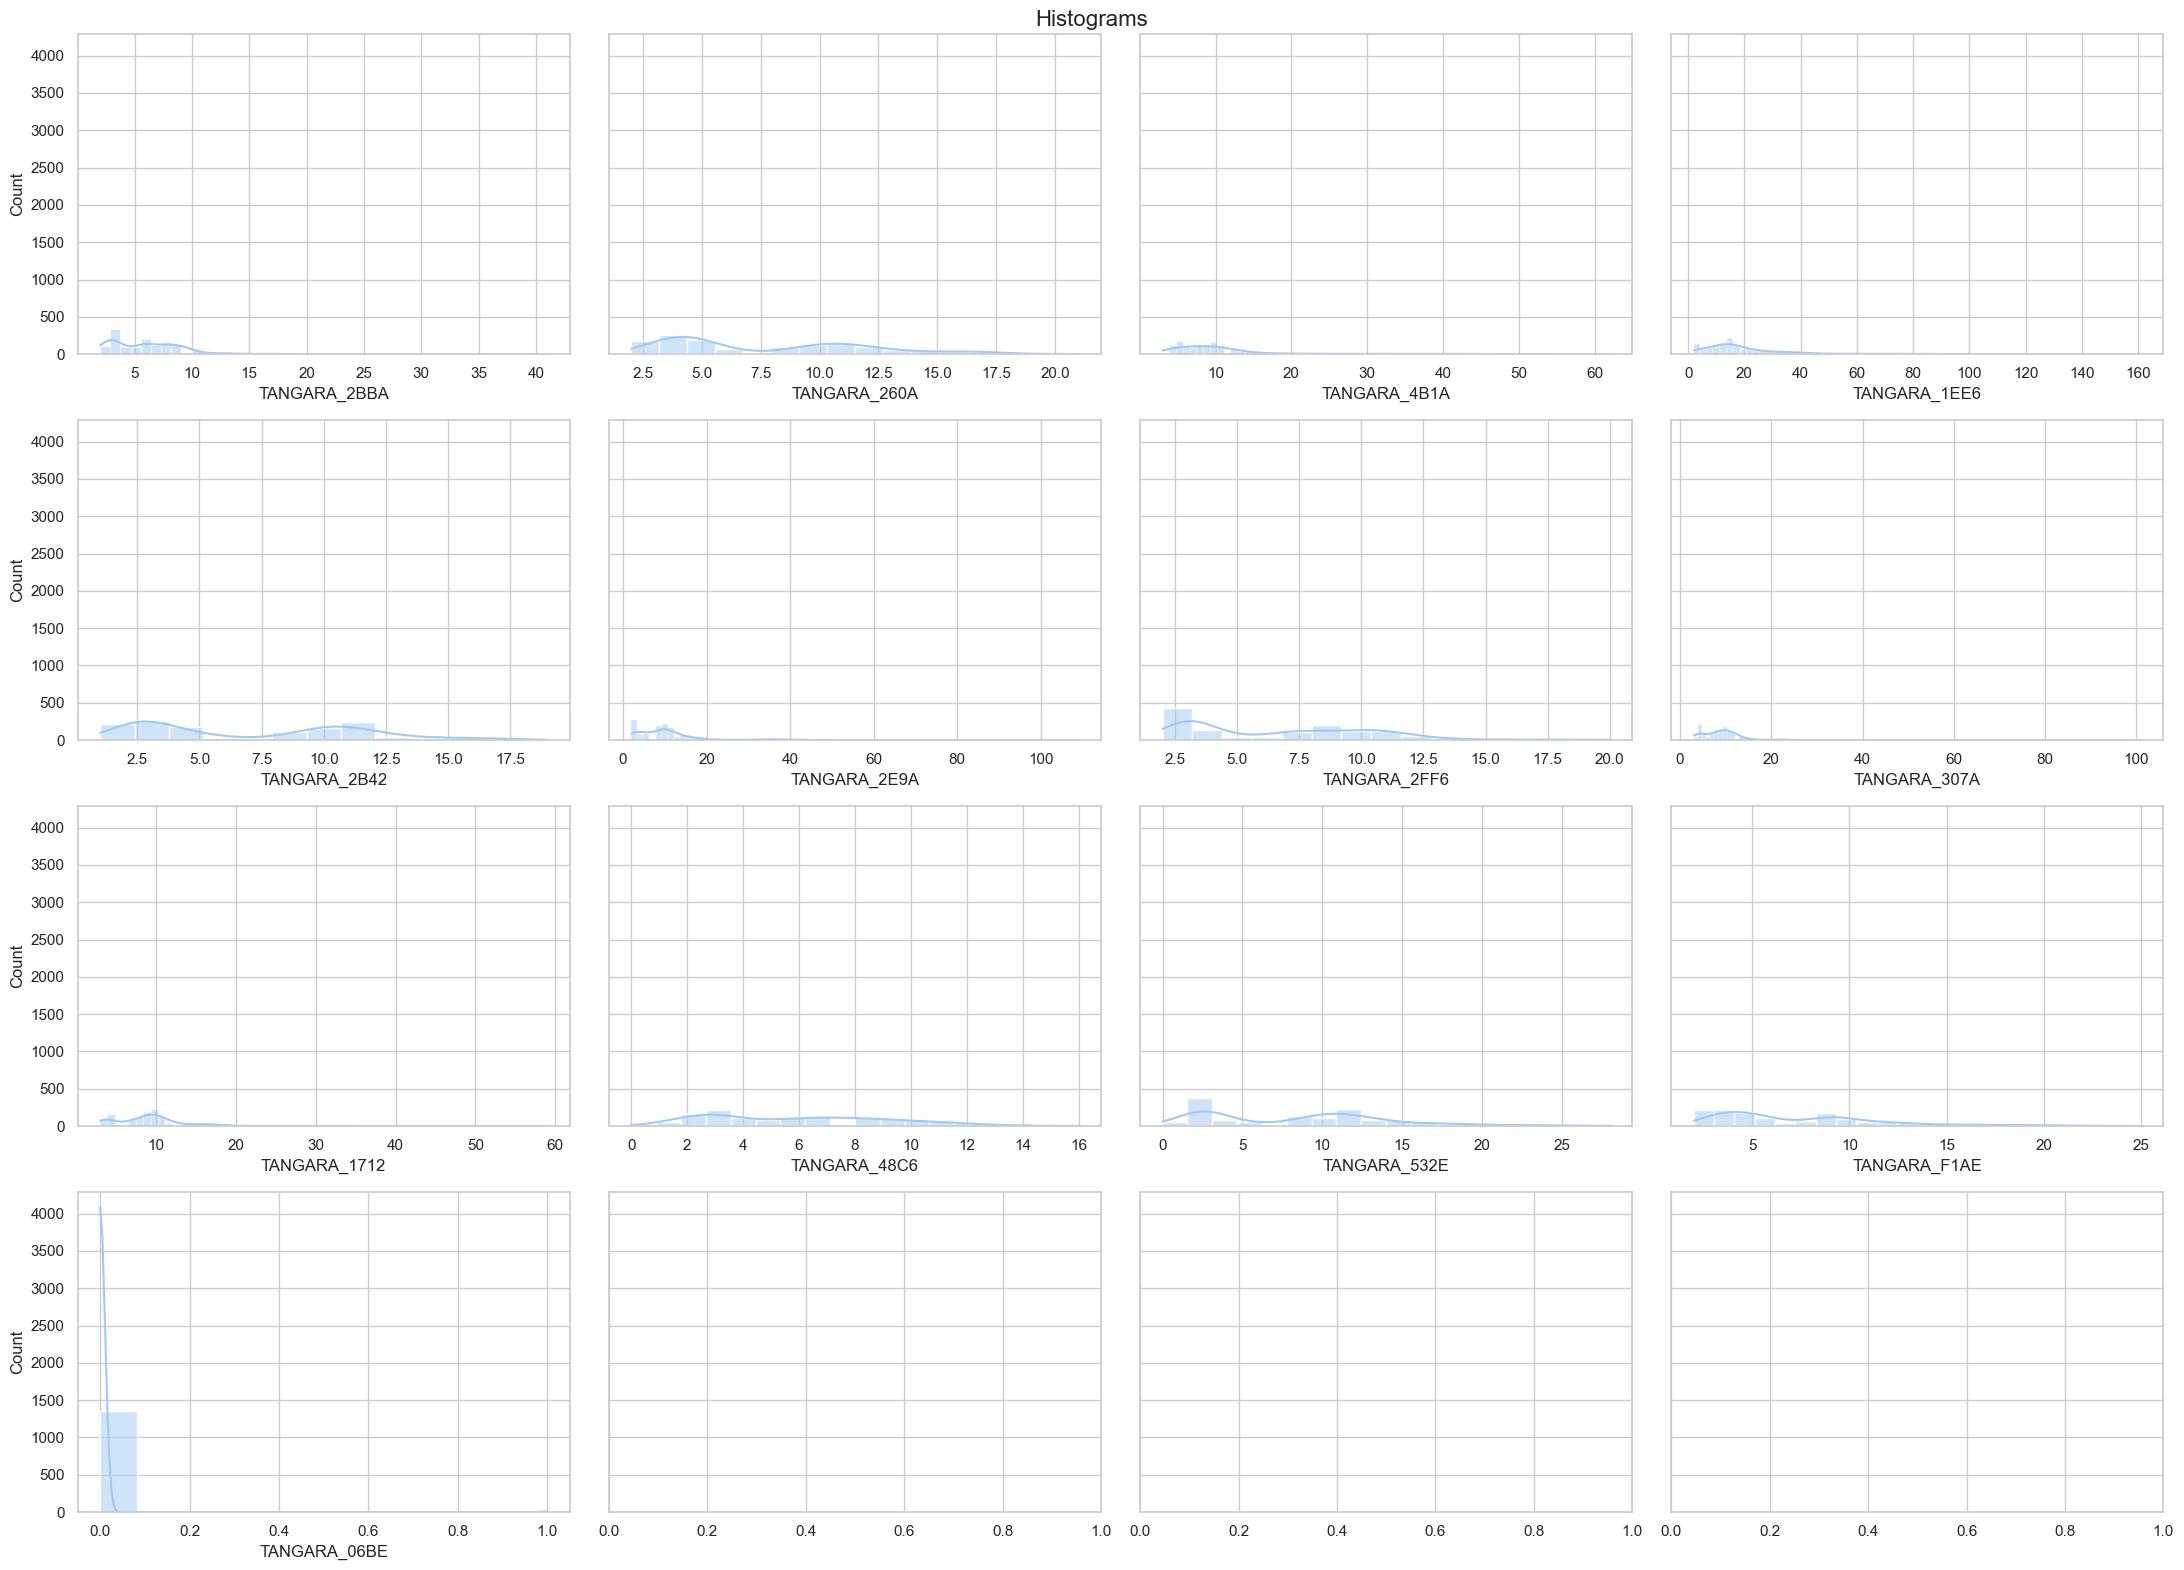

In [6]:
# Plot Histograms
plot_hist(df_pm25_raw)

## Boxplots

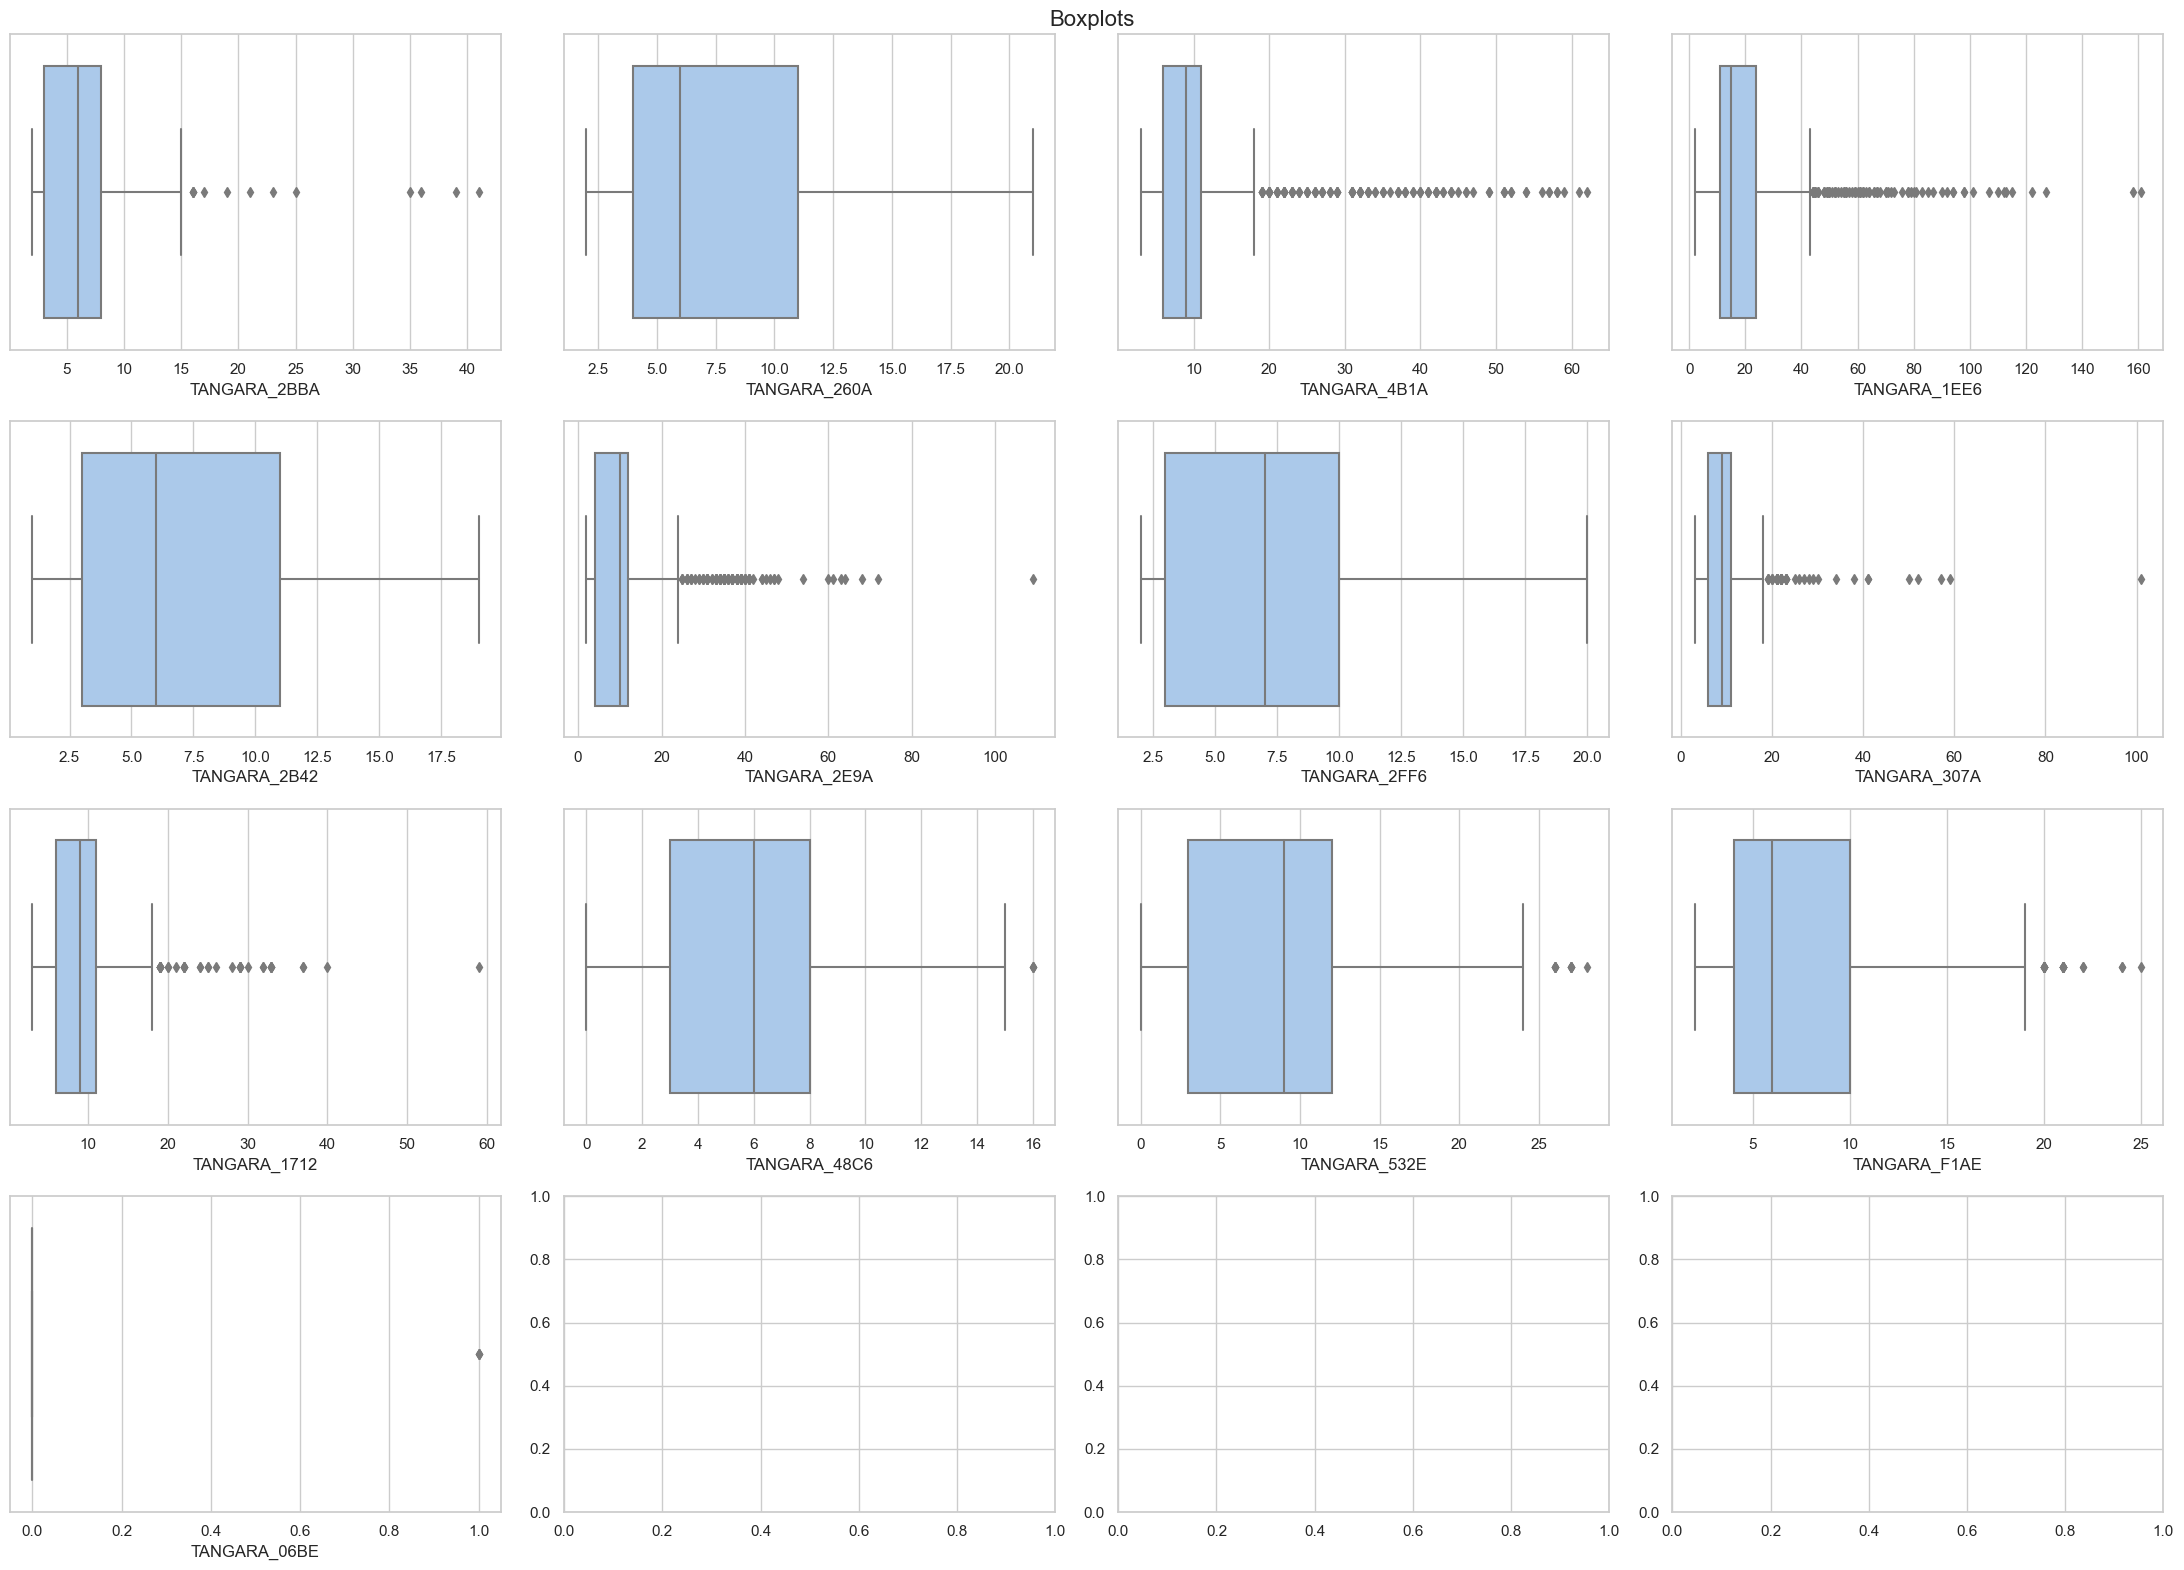

In [7]:
# Plot Boxplots
plot_boxes(df_pm25_raw)

## Lineplots

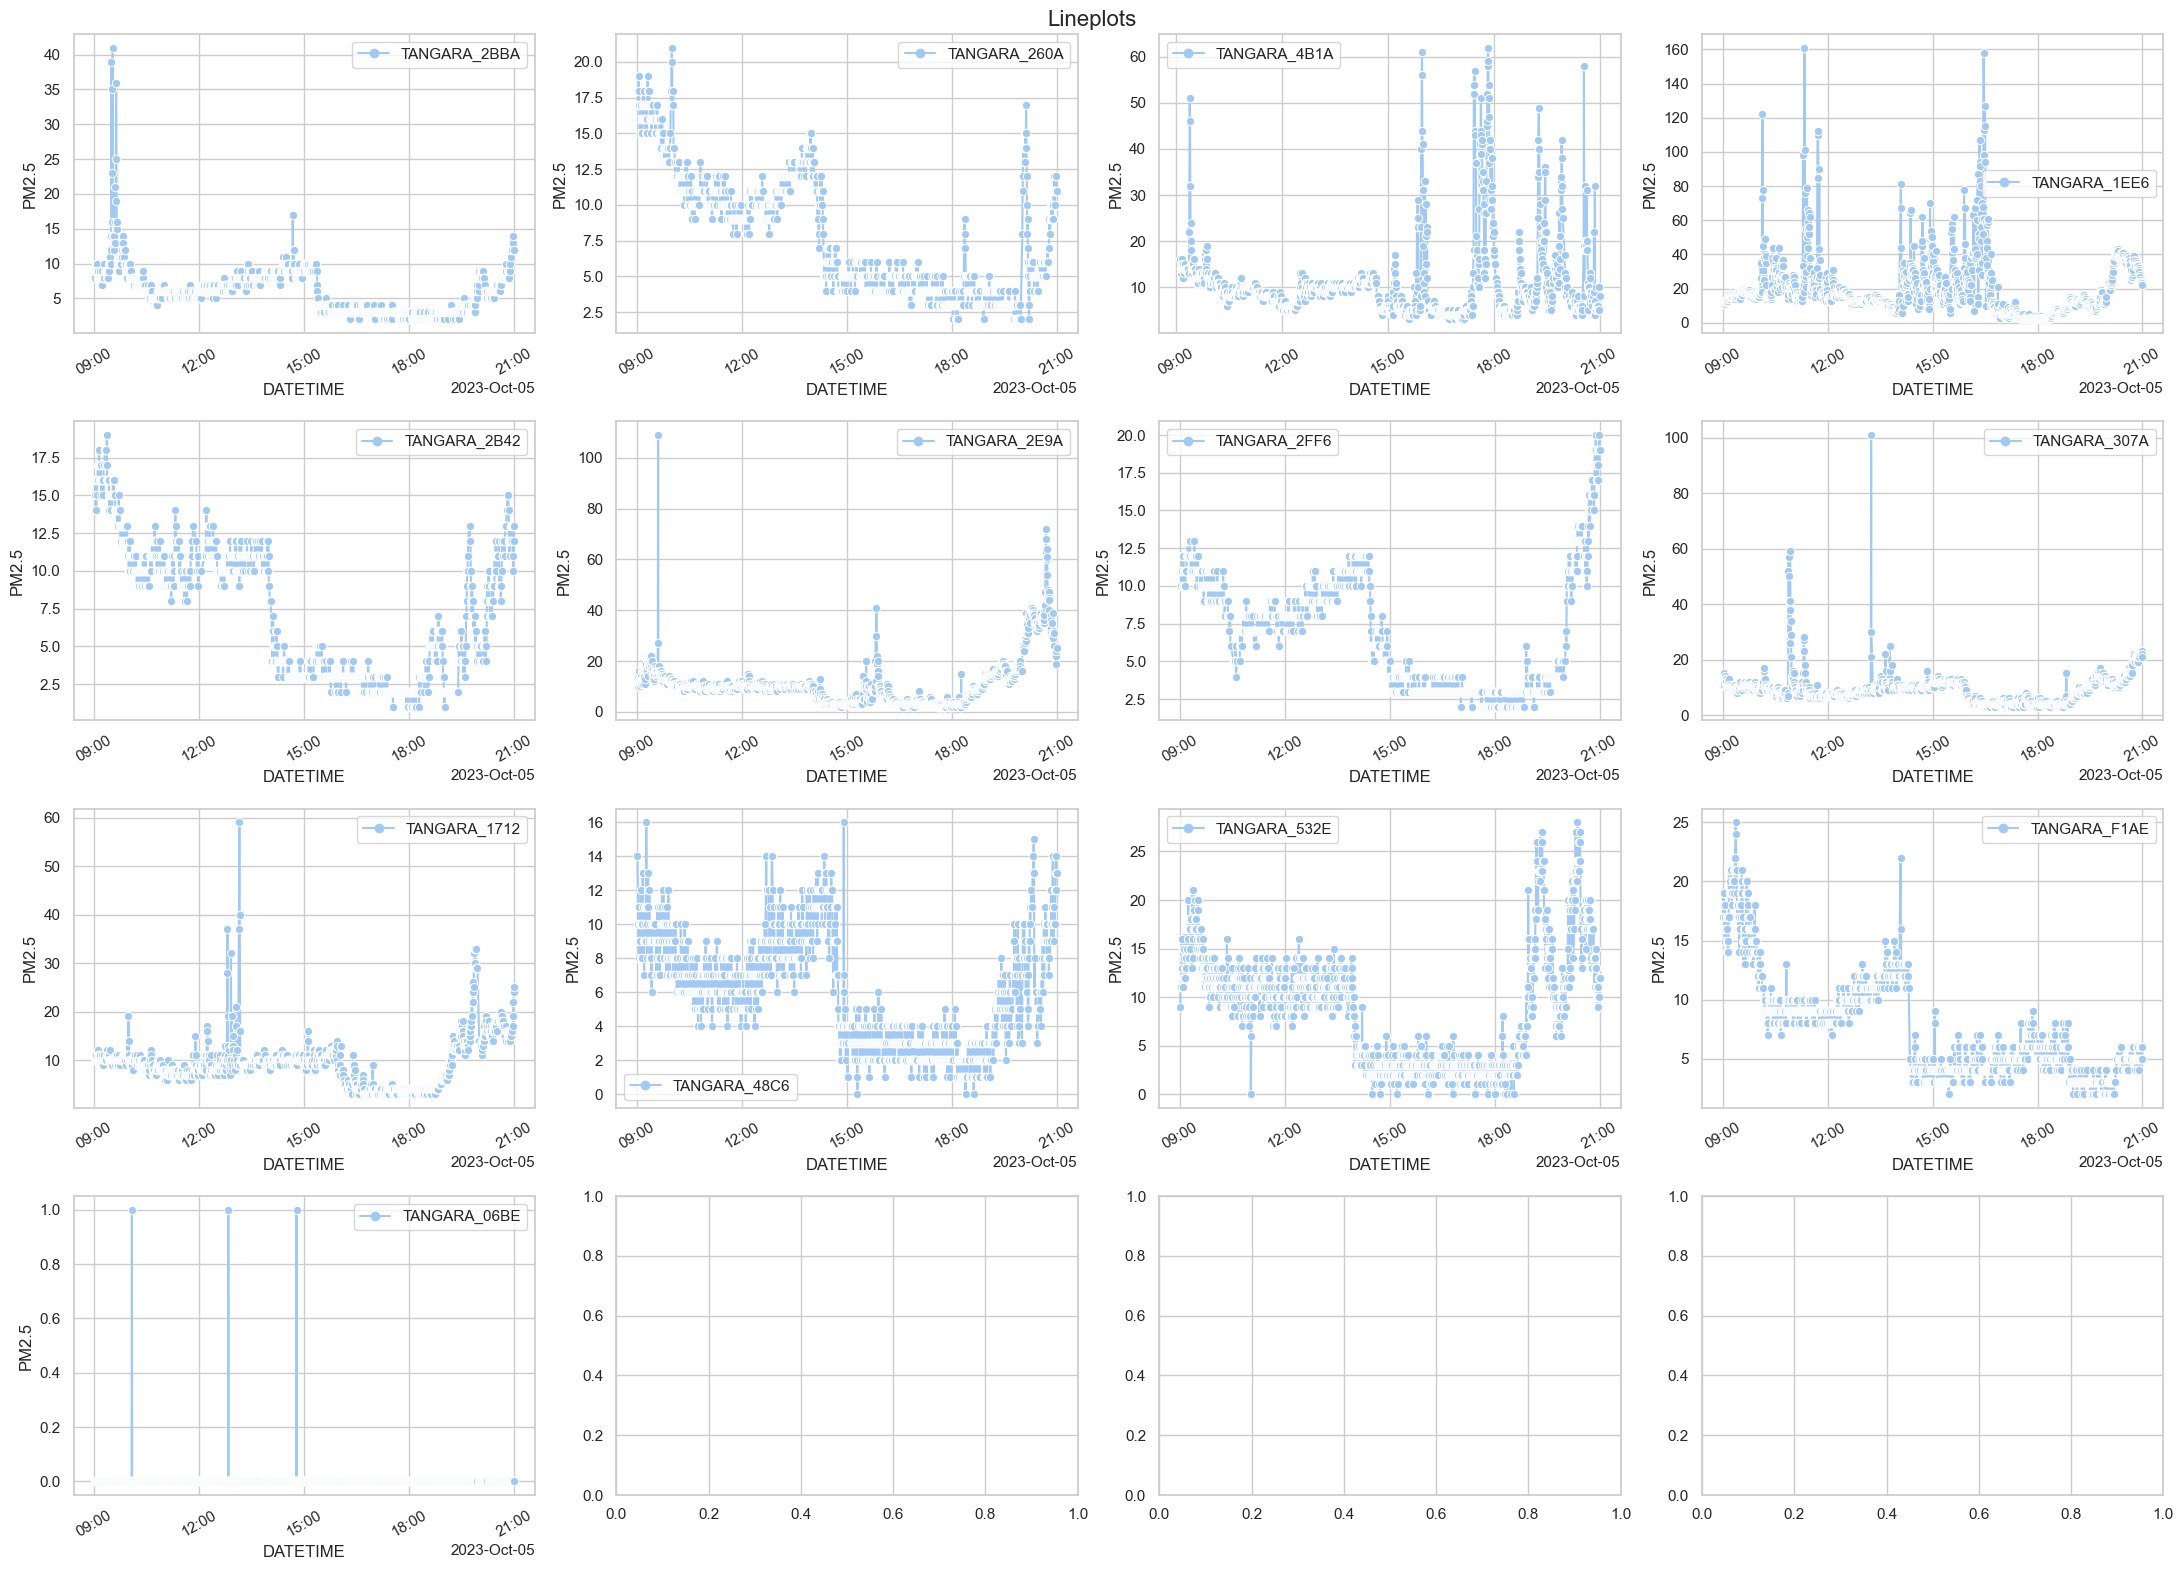

In [8]:
# Plot Lineplots
plot_lines(df_pm25_raw)

## Drop PM2.5 Outliers

In [9]:
# Drop PM2.5 Outliers
df_pm25_clean, resume = drop_pm25_outliers(df_pm25_raw)

In [10]:
# Describe Data
df_pm25_raw.describe()

,TANGARA_2BBA,TANGARA_260A,TANGARA_4B1A,TANGARA_1EE6,TANGARA_2B42,TANGARA_2E9A,TANGARA_2FF6,TANGARA_307A,TANGARA_1712,TANGARA_48C6,TANGARA_532E,TANGARA_F1AE,TANGARA_06BE
count,1357.000000,1357.000000,1222.000000,1270.000000,1334.000000,1250.000000,1333.000000,1286.000000,1303.000000,1310.000000,1339.000000,1337.000000,1360.0
mean,5.799558,7.803979,8.461538,16.456693,7.110945,8.733600,6.730683,8.503888,8.698388,5.951908,8.353996,7.264024,0.0
std,2.743386,4.207720,3.274963,9.654926,4.403979,4.642744,3.748304,3.188193,3.668321,3.216408,5.558374,3.921364,0.0
min,2.000000,2.000000,3.000000,2.000000,1.000000,2.000000,2.000000,3.000000,3.000000,0.000000,0.000000,2.000000,0.0
25%,3.000000,4.000000,6.000000,10.000000,3.000000,4.000000,3.000000,6.000000,6.000000,3.000000,3.000000,4.000000,0.0
50%,6.000000,6.000000,8.000000,15.000000,6.000000,9.000000,7.000000,9.000000,9.000000,6.000000,9.000000,6.000000,0.0
75%,8.000000,11.000000,11.000000,21.000000,11.000000,11.000000,10.000000,11.000000,11.000000,8.000000,12.000000,10.000000,0.0
max,15.000000,21.000000,18.000000,43.000000,19.000000,24.000000,20.000000,18.000000,18.000000,15.000000,24.000000,19.000000,0.0


In [11]:
# Describe Data
df_pm25_clean.describe()

,TANGARA_2BBA,TANGARA_260A,TANGARA_4B1A,TANGARA_1EE6,TANGARA_2B42,TANGARA_2E9A,TANGARA_2FF6,TANGARA_307A,TANGARA_1712,TANGARA_48C6,TANGARA_532E,TANGARA_F1AE,TANGARA_06BE
count,1357.000000,1357.000000,1222.000000,1270.000000,1334.000000,1250.000000,1333.000000,1286.000000,1303.000000,1310.000000,1339.000000,1337.000000,1360.0
mean,5.799558,7.803979,8.461538,16.456693,7.110945,8.733600,6.730683,8.503888,8.698388,5.951908,8.353996,7.264024,0.0
std,2.743386,4.207720,3.274963,9.654926,4.403979,4.642744,3.748304,3.188193,3.668321,3.216408,5.558374,3.921364,0.0
min,2.000000,2.000000,3.000000,2.000000,1.000000,2.000000,2.000000,3.000000,3.000000,0.000000,0.000000,2.000000,0.0
25%,3.000000,4.000000,6.000000,10.000000,3.000000,4.000000,3.000000,6.000000,6.000000,3.000000,3.000000,4.000000,0.0
50%,6.000000,6.000000,8.000000,15.000000,6.000000,9.000000,7.000000,9.000000,9.000000,6.000000,9.000000,6.000000,0.0
75%,8.000000,11.000000,11.000000,21.000000,11.000000,11.000000,10.000000,11.000000,11.000000,8.000000,12.000000,10.000000,0.0
max,15.000000,21.000000,18.000000,43.000000,19.000000,24.000000,20.000000,18.000000,18.000000,15.000000,24.000000,19.000000,0.0


## Histograms

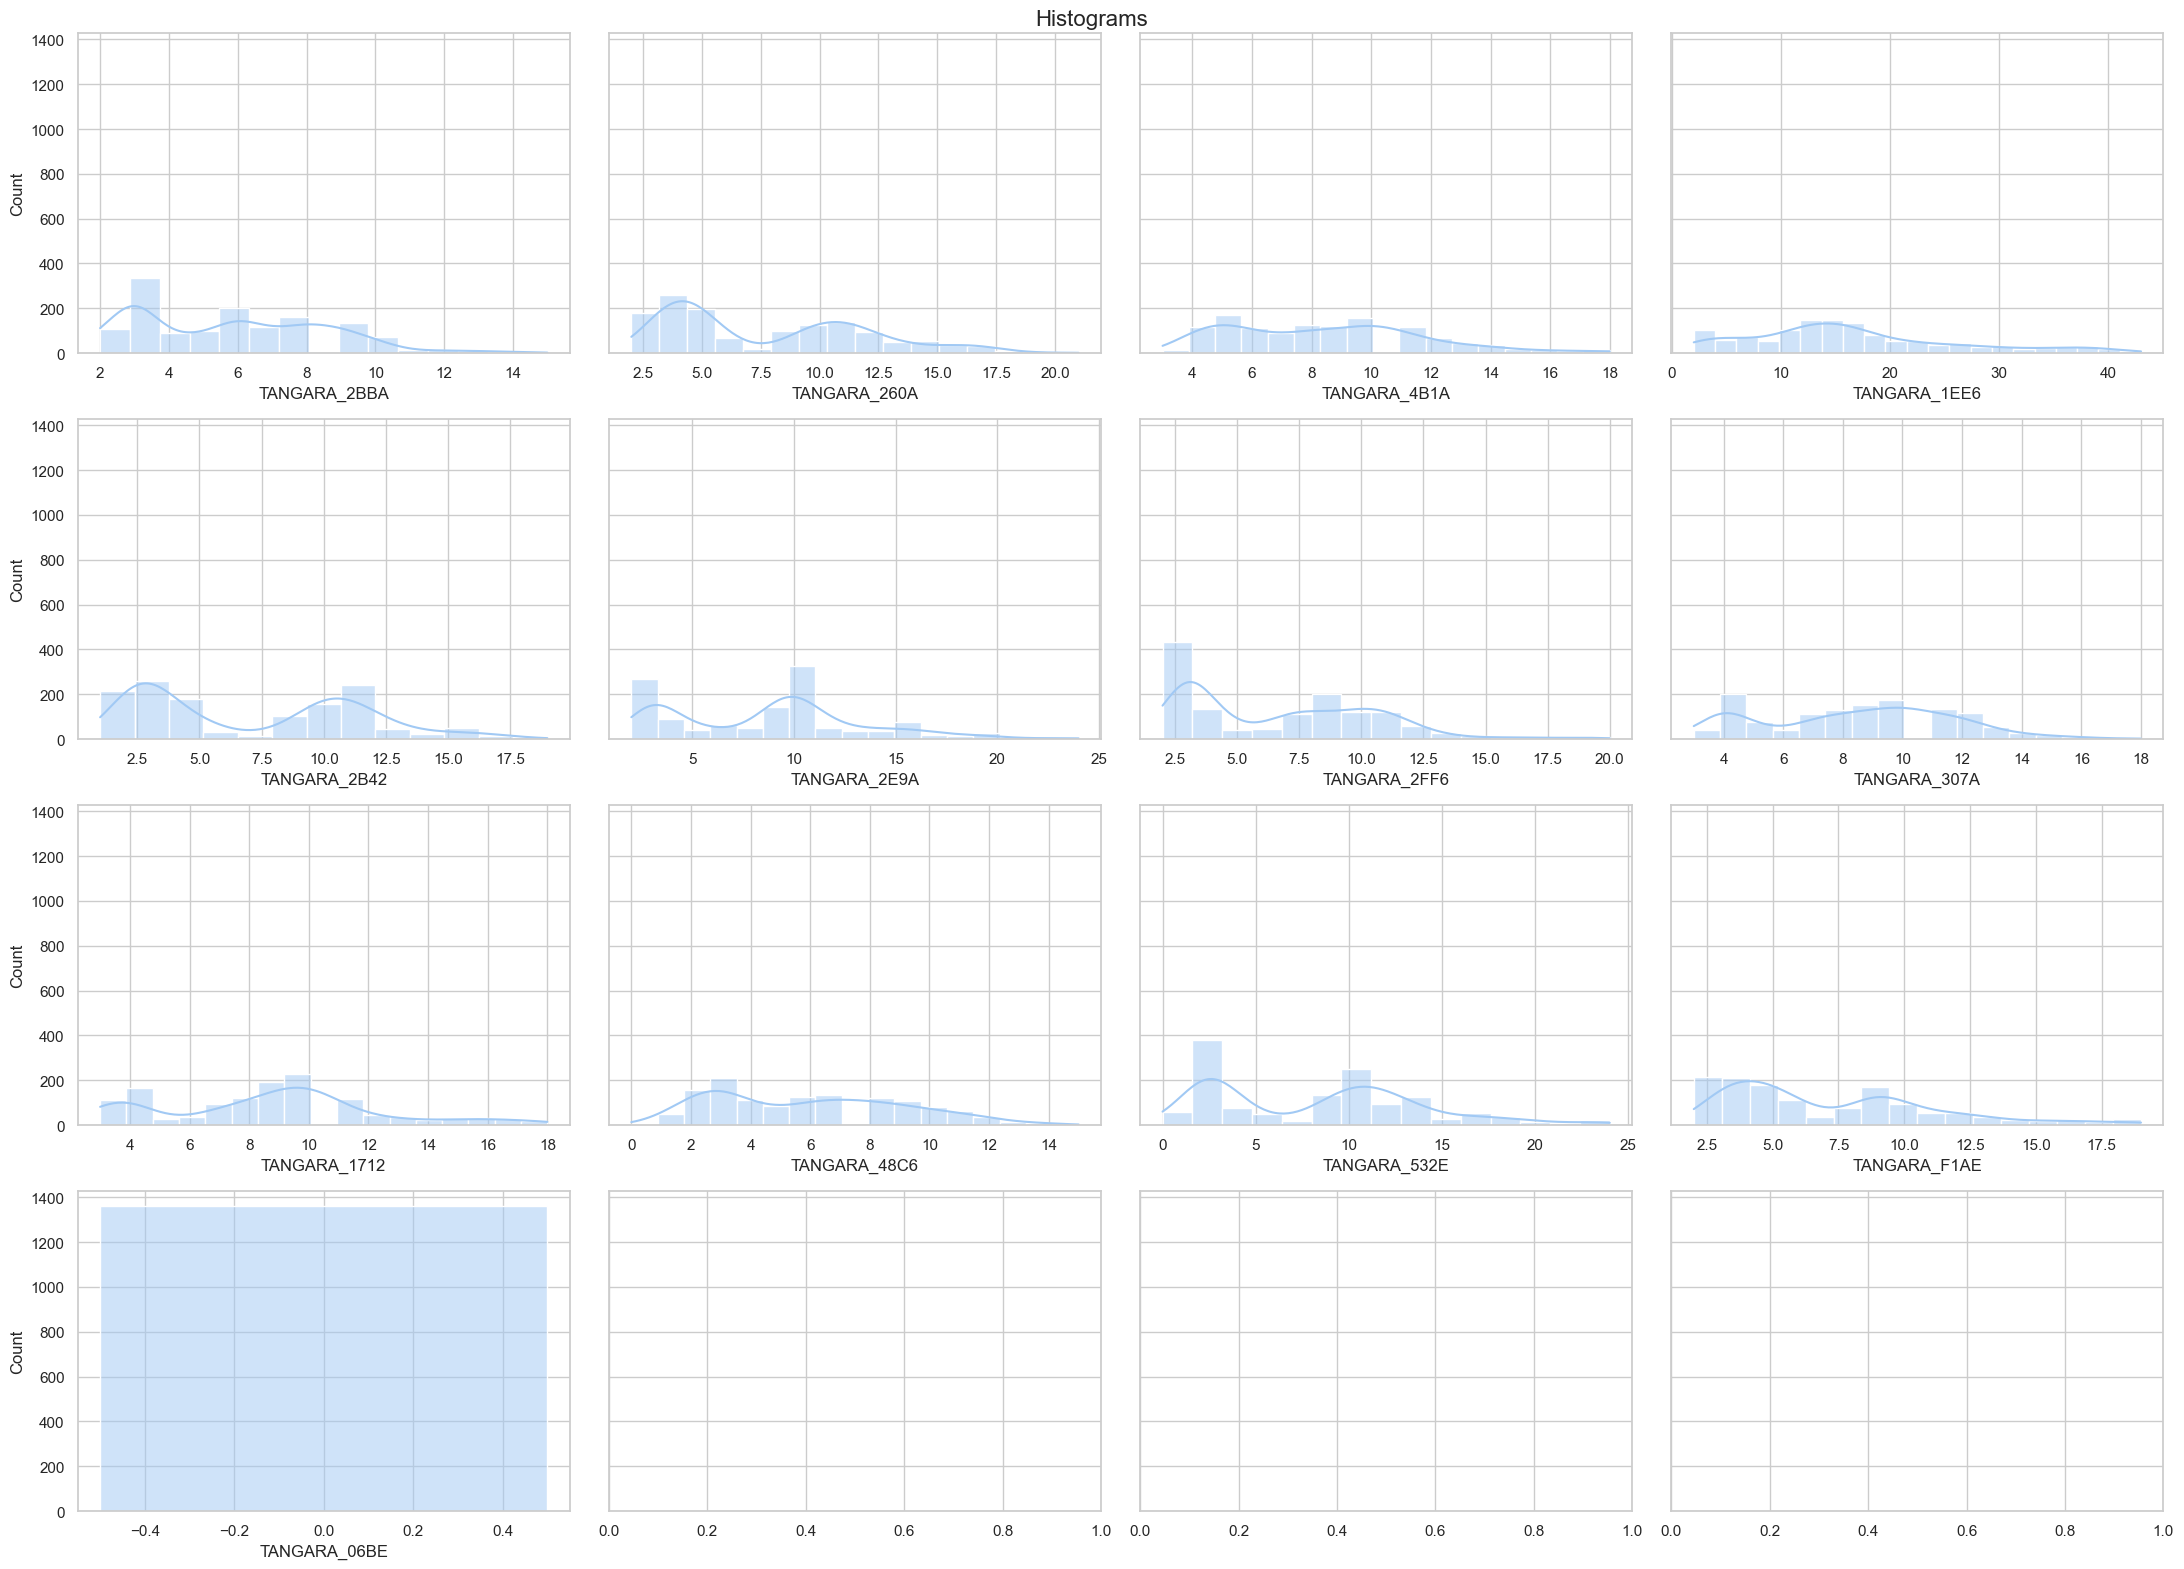

In [12]:
# Plot Histograms
plot_hist(df_pm25_clean)

## Boxplots

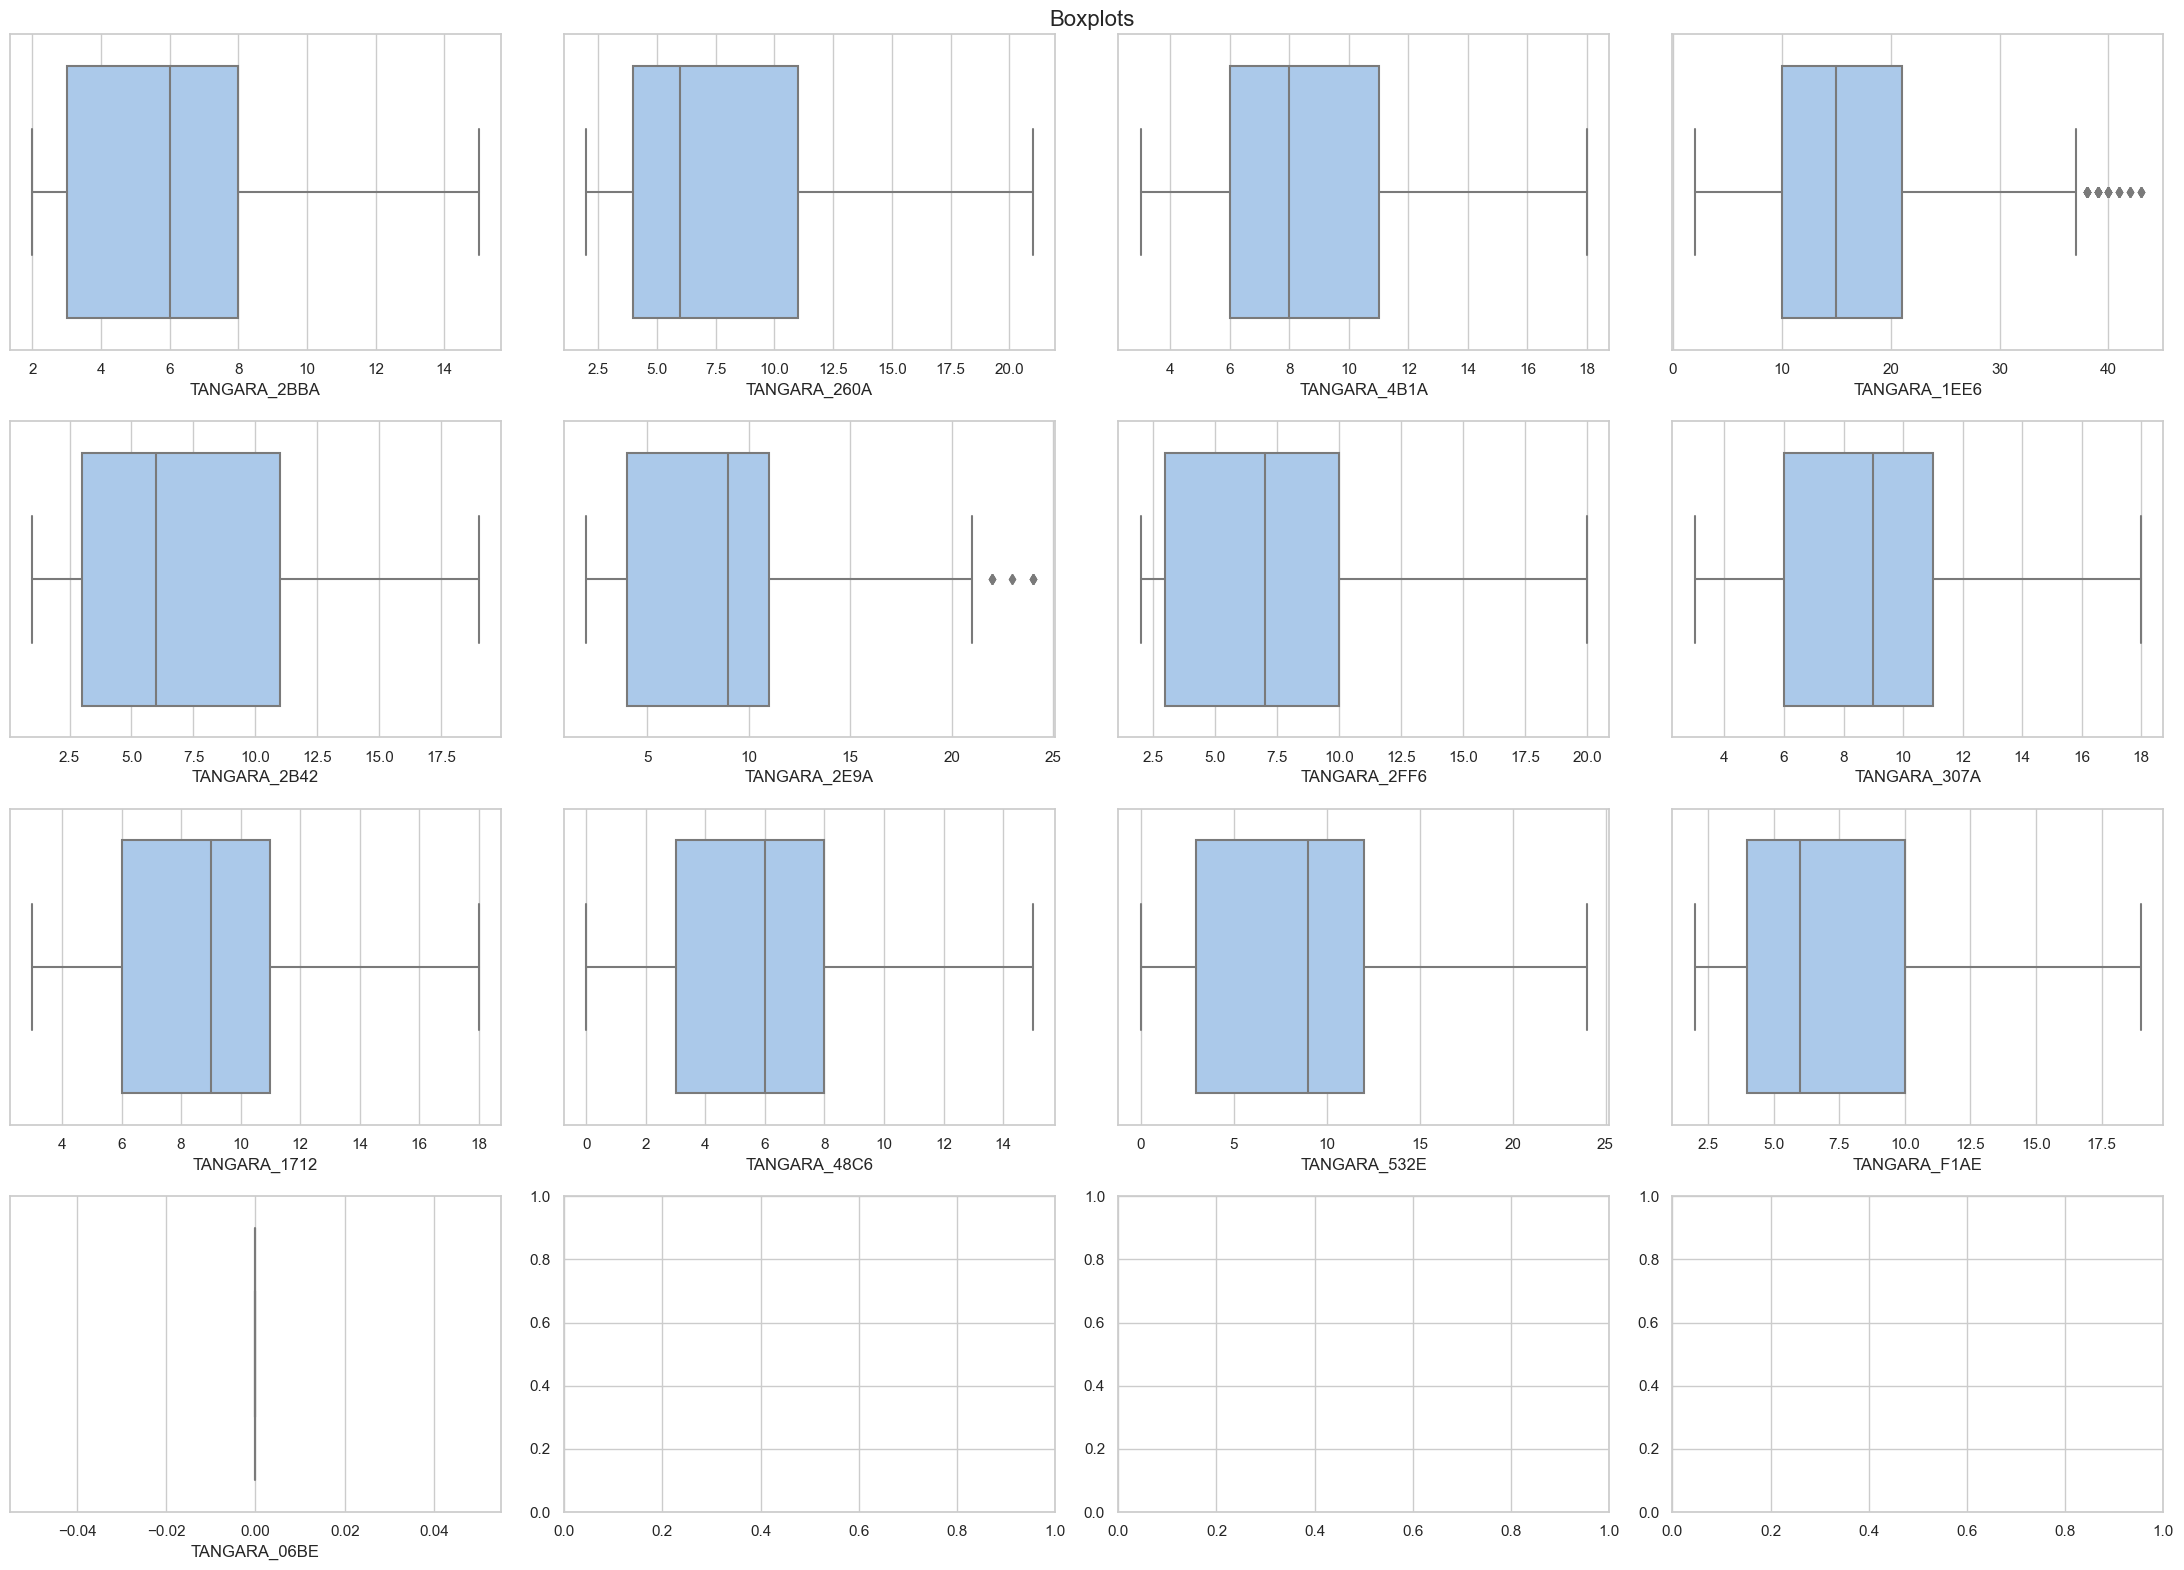

In [13]:
# Plot Boxplots
plot_boxes(df_pm25_clean)

## Lineplots

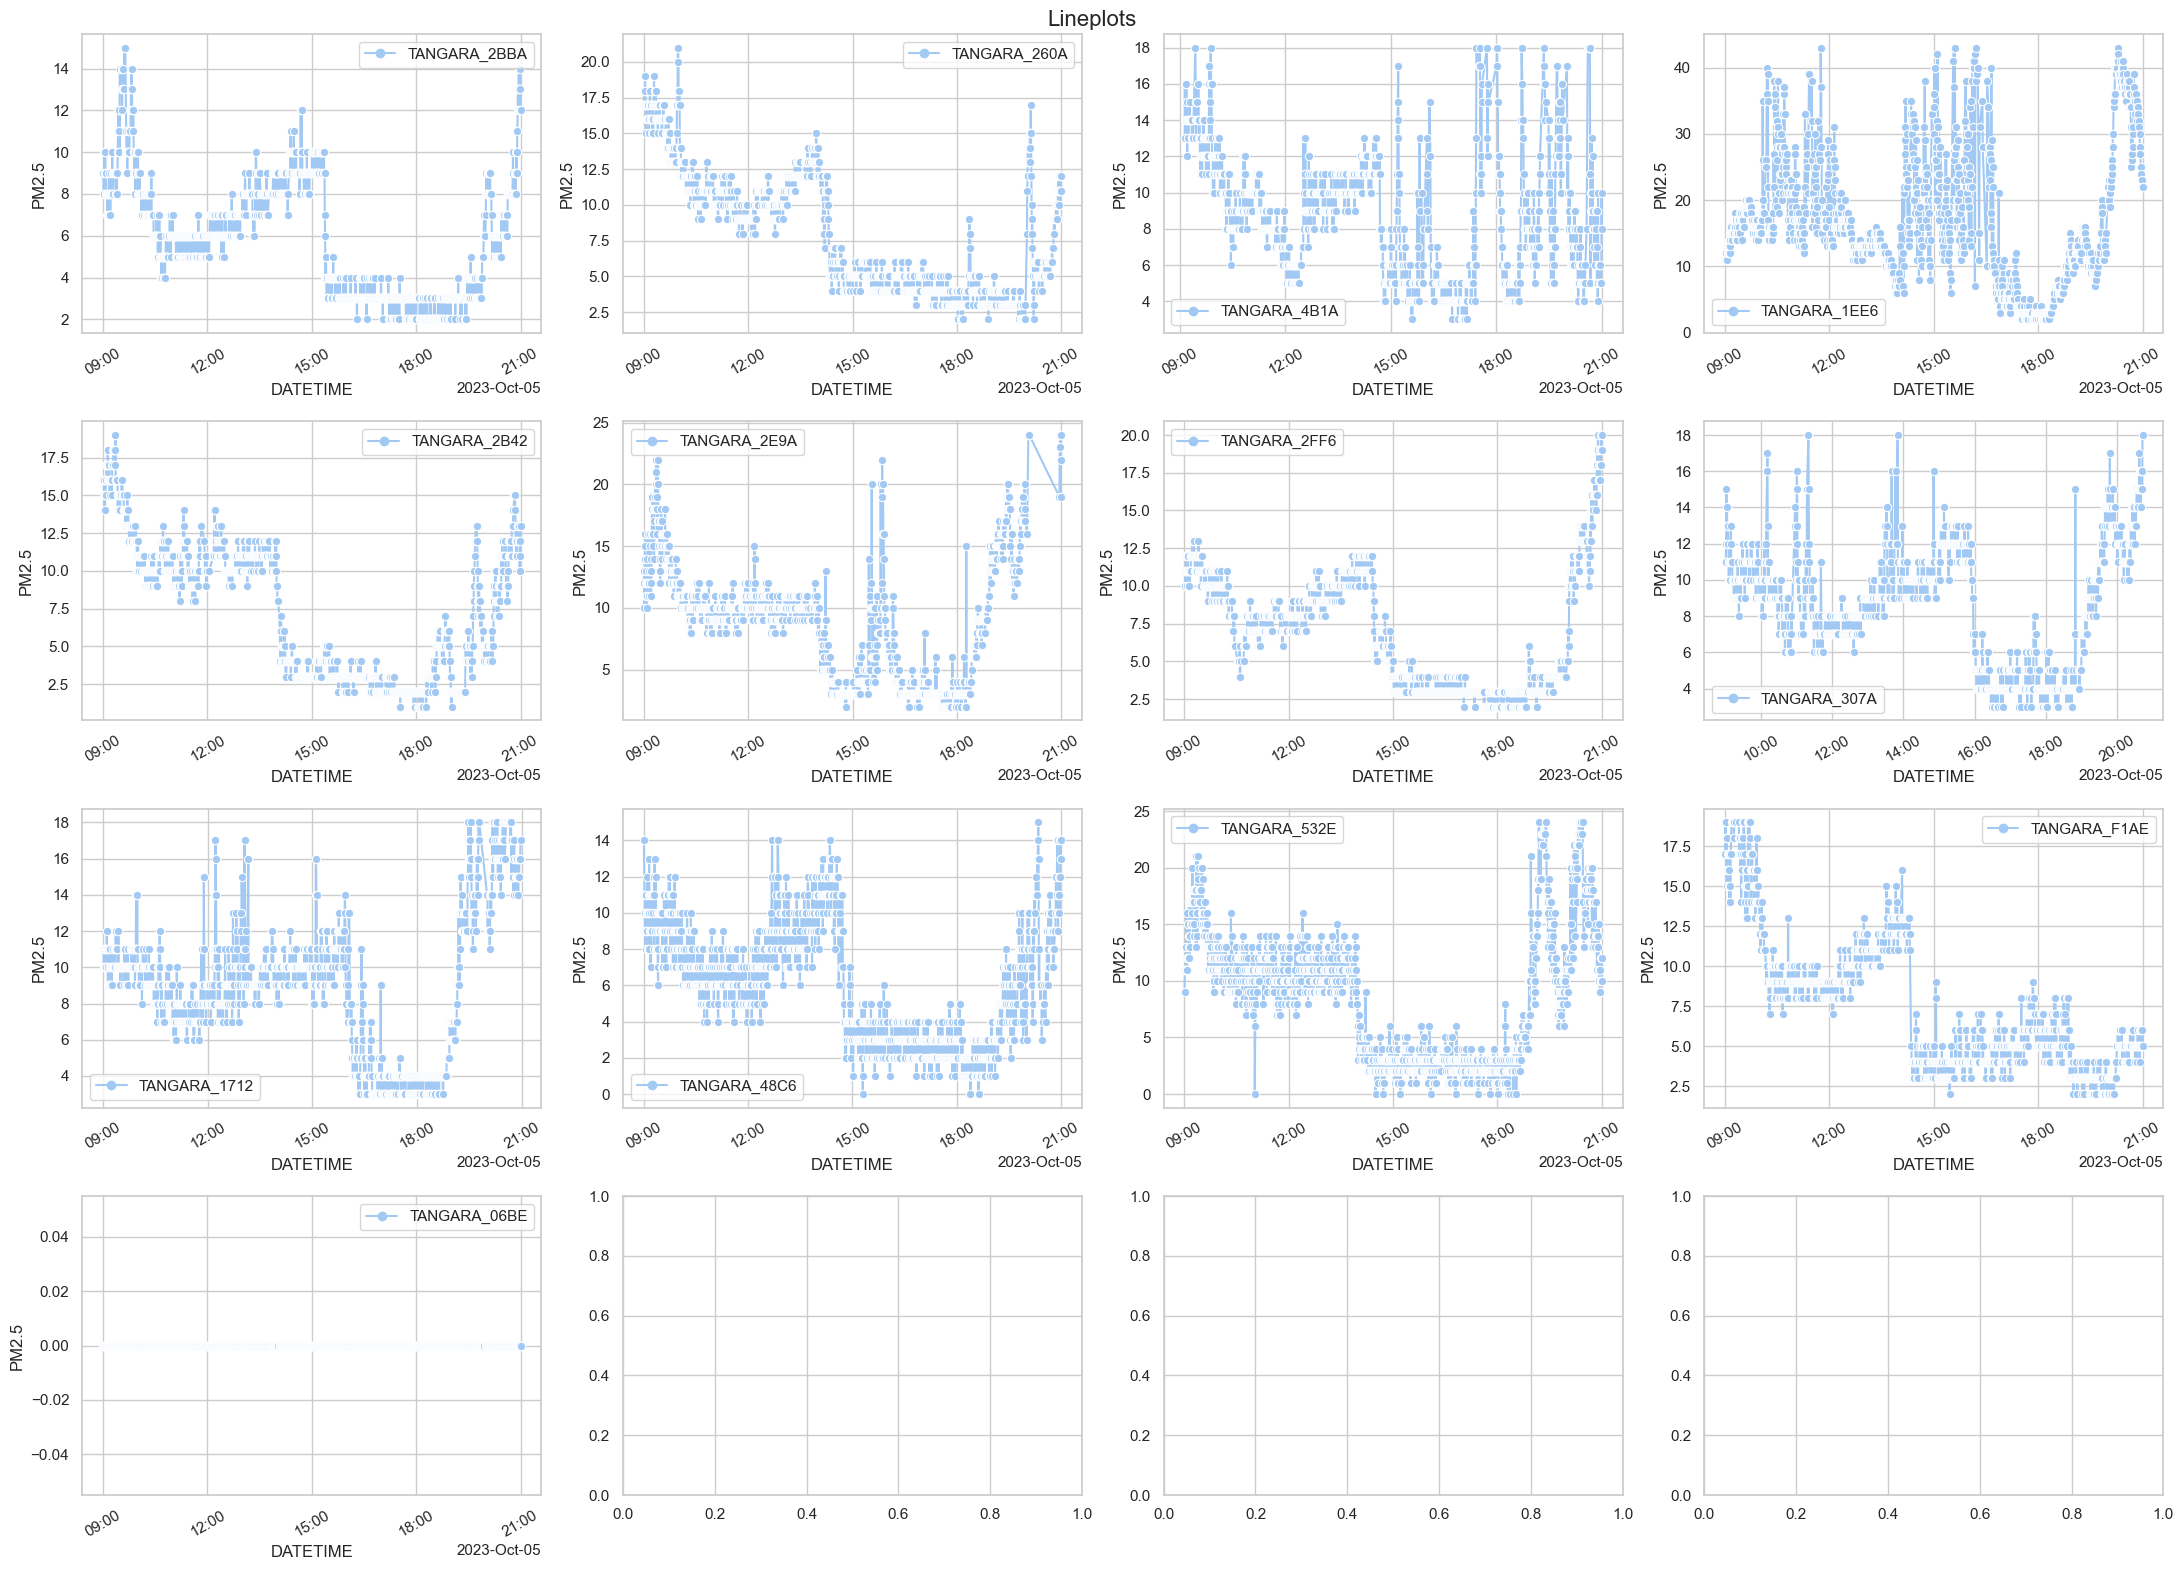

In [14]:
# Plot Lineplots
plot_lines(df_pm25_clean)

In [15]:
# Save PM2.5 Data Frame Sensors into CSV file
df_to_csv(df_pm25_clean, "pm25_clean.csv", datafolder='1_clean')